# Transportation Equilibrium Model: Deep Provenance Chains

This notebook demonstrates how Consist tracks provenance through an **iterative equilibrium model**—a common pattern in transportation, economics, and agent-based simulation where outputs feed back as inputs until the system converges.

## The Model

We simulate morning commute mode choice in a stylized 5-zone linear city:

```
Zone 1 ←→ Zone 2 ←→ Zone 3 ←→ Zone 4 ←→ Zone 5
(Low)     (Med)     (High/CBD)  (Med)     (Low)
```

**Feedback loop:**
1. **Logsums**: Compute accessibility from current travel times
2. **Trip Distribution**: Workers choose job locations based on accessibility
3. **Mode Choice**: Each commuter chooses car, transit, or walk
4. **Assignment**: Car trips create congestion
5. **Skim Update**: Congestion slows travel times → back to step 1

The model iterates until mode shares stabilize.

## Provenance Value

This structure lets us answer questions like:
- "Which iteration's skims were used to produce this trip table?"
- "If I change parking costs, which steps need to re-run?"
- "Can I resume from iteration 7 with a tighter convergence threshold?"


In [17]:
from __future__ import annotations

import sys
import uuid
from dataclasses import asdict, replace
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import consist
from consist import Tracker


def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repo root (missing pyproject.toml)")


REPO_ROOT = _find_repo_root(Path.cwd())
EXAMPLES_DIR = REPO_ROOT / "examples"
EXAMPLES_SRC = EXAMPLES_DIR / "src"

for path in (REPO_ROOT, EXAMPLES_SRC):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

from travel_demand_functions import (
    AssignmentParams,
    DestinationChoiceParams,
    ModeChoiceParams,
    TravelDemandScenarioConfig,
    ZoneParams,
    apply_congestion,
    apply_mode_choice,
    compute_mode_shares,
    compute_mode_utilities,
    compute_od_logsums,
    compute_od_volumes,
    create_skims_dataset,
    distribute_trips,
    generate_distances,
    generate_population,
    generate_zones,
    save_skims,
    summarize_iteration,
)

sns.set_theme(style="whitegrid")

## Setup

We initialize the tracker and import our model functions. Each run gets a unique session ID so we can compare multiple runs in the same database.

In [18]:
EXAMPLES_DIR = REPO_ROOT / "examples"
RUN_DIR = EXAMPLES_DIR / "runs" / "travel_demand_demo"
SESSION_ID = uuid.uuid4().hex[:8]
DB_PATH = RUN_DIR / f"travel_demand_demo_{SESSION_ID}.duckdb"

tracker = Tracker(run_dir=RUN_DIR, db_path=DB_PATH, hashing_strategy="fast")

[SQL: ALTER TABLE run DROP CONSTRAINT IF EXISTS fk_run_parent]
(Background on this error at: https://sqlalche.me/e/20/tw8g)


## Model Configuration

The model has four parameter groups:

| Parameter Group           | Controls                                                     |
|---------------------------|--------------------------------------------------------------|
| `ZoneParams`              | City layout: population, jobs, parking costs, transit access |
| `ModeChoiceParams`        | Utility coefficients, speeds, costs                          |
| `DestinationChoiceParams` | How accessibility affects job location choice                |
| `AssignmentParams`        | BPR congestion function parameters                           |

**ZoneParams** defines the city structure. The central zone (Zone 3) has the most jobs and highest parking costs, mimicking a downtown CBD. Outer zones are residential with cheaper or free parking.

**ModeChoiceParams** sets the coefficients for a standard multinomial logit mode choice model. `beta_cost` and `beta_time` control sensitivity to travel cost and time; the ASCs (alternative-specific constants) capture baseline preferences for transit and walking relative to driving.

**DestinationChoiceParams** governs how workers choose job locations. `beta_access` weights the logsum (a measure of how easy it is to reach a zone by any mode), while `beta_size` weights employment size.

**AssignmentParams** controls the BPR (Bureau of Public Roads) volume-delay function that converts traffic volumes into congested travel times.

We also set two equilibrium parameters:
- `SKIM_PERTURBATION`: Initial congestion multiplier (starts the system away from equilibrium so we can watch it converge)
- `DESTINATION_UPDATE_SHARE`: Damping factor for stability (blend new destination choices with previous iteration to prevent oscillation)

In [19]:
zone_params = ZoneParams()
mode_params = ModeChoiceParams()
dest_params = DestinationChoiceParams()
assignment_params = AssignmentParams()

DEFAULT_SEED = 0

base_config = TravelDemandScenarioConfig(
    n_iterations=10,
    seed=DEFAULT_SEED,
    zone_params=zone_params,
    mode_params=mode_params,
    dest_params=dest_params,
    assignment_params=assignment_params,
)

SCENARIO_NAME = "travel_demand_demo"

SKIM_PERTURBATION = 2.0
DESTINATION_UPDATE_SHARE = 0.4

## Baseline Scenario

We run the equilibrium loop, tracking each step's inputs and outputs. The coupler passes artifacts between steps within the scenario—when we update `skims` after traffic simulation, the next iteration's logsum calculation automatically picks up the congested version.

### Step Structure per Iteration

```
┌─────────────┐
│    init     │ (iteration 0 only)
└──────┬──────┘
       │ skims, zones, population
       ▼
┌─────────────┐
│   logsums   │◄─── skims, zones
└──────┬──────┘
       │ logsums
       ▼
┌─────────────┐
│ trip_dist   │◄─── logsums, zones, population
└──────┬──────┘
       │ trips
       ▼
┌─────────────┐
│ utilities   │◄─── trips, skims, zones
└──────┬──────┘
       │ utilities
       ▼
┌─────────────┐
│ mode_choice │◄─── utilities, (prev trips_with_modes)
└──────┬──────┘
       │ trips_with_modes
       ▼
┌─────────────┐
│ assignment  │◄─── trips_with_modes
└──────┬──────┘
       │ volumes
       ▼
┌─────────────┐
│ traffic_sim │◄─── volumes, skims
└──────┬──────┘
       │ updated skims ──► next iteration
       ▼
```

In [20]:
def run_scenario(scenario_config, scenario_run_id):
    mode_shares = {}
    summaries = {}
    pmt_totals = {}

    zone_params = scenario_config.zone_params
    mode_params = scenario_config.mode_params
    dest_params = scenario_config.dest_params
    assignment_params = scenario_config.assignment_params
    seed = scenario_config.seed

    with tracker.scenario(
        scenario_run_id,
        config={
            **asdict(scenario_config),
            "scenario_name": SCENARIO_NAME,
        },
        facet_from=["n_iterations"],
        tags=["examples", "simulation", "travel_demand"],
    ) as scenario:
        scenario_output_dir = RUN_DIR / scenario.run_id
        scenario_output_dir.mkdir(parents=True, exist_ok=True)
        input_dir = scenario_output_dir / "travel_demand_input"
        input_dir.mkdir(parents=True, exist_ok=True)

        def _init():
            zones = generate_zones(zone_params)
            population = generate_population(zones)
            distances = generate_distances(zone_params)

            skims = create_skims_dataset(zones, distances, mode_params)
            skims["time_car_mins"] *= SKIM_PERTURBATION

            input_skims_path = input_dir / "skims_init.zarr"
            input_persons_path = input_dir / "population_init.parquet"
            input_zones_path = input_dir / "zones.parquet"

            save_skims(skims, input_skims_path)

            consist.log_artifact(input_skims_path, key="skims", direction="output")
            consist.log_dataframe(
                population,
                key="persons",
                direction="output",
                path=input_persons_path,
            )
            consist.log_dataframe(
                zones, key="zones", direction="output", path=input_zones_path
            )

        scenario.run_step(
            name="init",
            fn=_init,
            config=asdict(mode_params)
            | asdict(zone_params)
            | {"skim_perturbation": SKIM_PERTURBATION},
            facet_from=["skim_perturbation"],
            outputs=["skims", "persons", "zones"],
        )

        for i in tqdm(range(scenario_config.n_iterations)):
            output_dir = scenario_output_dir / f"iteration_{i}"
            output_dir.mkdir(parents=True, exist_ok=True)

            def _logsums():
                skims = consist.load(scenario.coupler.require("skims"))
                zones = consist.load(scenario.coupler.require("zones"))
                logsums = compute_od_logsums(skims, zones, mode_params)
                consist.log_dataframe(
                    logsums.to_dataframe().reset_index(),
                    key="logsums",
                    path=output_dir / "logsums.parquet",
                )

            scenario.run_step(
                name="logsums",
                fn=_logsums,
                run_id=f"{scenario.run_id}_logsums_{i}",
                config=asdict(mode_params),
                input_keys=["skims", "zones"],
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                    "fuel_cost_per_mile",
                    "transit_fare",
                ],
                outputs=["logsums"],
                iteration=i,
            )

            def _trip_distribution():
                skims = consist.load(scenario.coupler.require("skims"))
                zones = consist.load(scenario.coupler.require("zones"))
                population = consist.load(scenario.coupler.require("persons"))
                prev_trips_art = scenario.coupler.get("trips")
                prev_trips = consist.load(prev_trips_art) if prev_trips_art else None
                logsums_df = consist.load(scenario.coupler.require("logsums"))
                if (
                    "origin" not in logsums_df.columns
                    or "destination" not in logsums_df.columns
                ):
                    logsums_df = logsums_df.reset_index()
                logsums = logsums_df.set_index(["origin", "destination"])[
                    "logsum"
                ].to_xarray()
                trips = distribute_trips(
                    population,
                    zones,
                    logsums,
                    dest_params,
                    seed=seed + i,
                    prev_trips=prev_trips,
                    update_share=DESTINATION_UPDATE_SHARE,
                )
                consist.log_dataframe(
                    trips, key="trips", path=output_dir / "trips.parquet"
                )

            scenario.run_step(
                name="trip_distribution",
                fn=_trip_distribution,
                run_id=f"{scenario.run_id}_trip_distribution_{i}",
                config={
                    **asdict(dest_params),
                    "update_share": DESTINATION_UPDATE_SHARE,
                },
                input_keys=["skims", "zones", "persons", "logsums"],
                optional_input_keys=["trips"],
                facet_from=["beta_size", "beta_access", "update_share"],
                outputs=["trips"],
                iteration=i,
            )

            def _calculate_utilities():
                trips = consist.load(scenario.coupler.require("trips"))
                skims = consist.load(scenario.coupler.require("skims"))
                zones = consist.load(scenario.coupler.require("zones"))
                utilities = compute_mode_utilities(trips, skims, zones, mode_params)
                consist.log_dataframe(
                    utilities, key="utilities", path=(output_dir / "utilities.parquet")
                )

            scenario.run_step(
                name="calculate_utilities",
                fn=_calculate_utilities,
                run_id=f"{scenario.run_id}_utilities_{i}",
                config=asdict(mode_params),
                input_keys=["trips", "skims", "zones"],
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                ],
                outputs=["utilities"],
                iteration=i,
            )

            def _mode_choice():
                utilities = consist.load(scenario.coupler.require("utilities"))
                trips_with_modes = apply_mode_choice(utilities, seed=seed + i)
                consist.log_dataframe(
                    trips_with_modes,
                    key="trips_with_modes",
                    path=output_dir / "trips_with_modes.parquet",
                )

            scenario.run_step(
                name="mode_choice",
                fn=_mode_choice,
                run_id=f"{scenario.run_id}_mode_choice_{i}",
                config={"seed": seed},
                input_keys=["trips", "utilities"],
                outputs=["trips_with_modes"],
                iteration=i,
            )

            def _assignment():
                trips_with_modes = consist.load(
                    scenario.coupler.require("trips_with_modes")
                )
                volumes = compute_od_volumes(trips_with_modes)
                consist.log_dataframe(
                    volumes, key="volumes", path=(output_dir / "volumes.parquet")
                )

            scenario.run_step(
                name="assignment",
                fn=_assignment,
                run_id=f"{scenario.run_id}_assignment_{i}",
                input_keys=["trips_with_modes"],
                outputs=["volumes"],
                iteration=i,
            )

            def _traffic_simulation():
                volumes = consist.load(scenario.coupler.require("volumes"))
                skims = consist.load(scenario.coupler.require("skims"))
                skims = apply_congestion(skims, volumes, assignment_params)
                output_skims_path = output_dir / "skims_out.zarr"
                save_skims(skims, output_skims_path)
                consist.log_artifact(output_skims_path, key="skims", direction="output")

            scenario.run_step(
                name="traffic_simulation",
                fn=_traffic_simulation,
                run_id=f"{scenario.run_id}_traffic_simulation_{i}",
                config=asdict(assignment_params),
                input_keys=["volumes", "skims"],
                facet_from=["bpr_alpha", "bpr_beta", "base_capacity"],
                outputs=["skims"],
                iteration=i,
            )

            trips_with_modes = consist.load(
                scenario.coupler.require("trips_with_modes")
            )
            shares = compute_mode_shares(trips_with_modes)
            mode_shares[i] = pd.Series(shares)
            distance_by_mode = trips_with_modes.groupby("mode")["distance_miles"].sum()
            pmt_totals[i] = distance_by_mode.sort_index()
            summaries[i] = summarize_iteration(i, trips_with_modes, shares, 0, False)

        def _summaries():
            summary_dir = scenario_output_dir / "summary"
            summary_dir.mkdir(parents=True, exist_ok=True)

            mode_shares_df = (
                pd.DataFrame.from_dict(mode_shares, orient="index")
                .sort_index()
                .rename_axis("iteration")
                .reset_index()
            )
            summaries_df = (
                pd.DataFrame.from_dict(summaries, orient="index")
                .sort_values("iteration")
                .reset_index(drop=True)
            )
            pmt_totals_df = (
                pd.DataFrame.from_dict(pmt_totals, orient="index")
                .sort_index()
                .rename_axis("iteration")
                .reset_index()
            )

            mode_shares_path = summary_dir / "mode_shares.csv"
            summaries_path = summary_dir / "iteration_summaries.csv"
            pmt_totals_path = summary_dir / "pmt_totals.csv"
            mode_shares_df.to_csv(mode_shares_path, index=False)
            summaries_df.to_csv(summaries_path, index=False)
            pmt_totals_df.to_csv(pmt_totals_path, index=False)

            shares_long = mode_shares_df.melt(
                id_vars="iteration", var_name="mode", value_name="share"
            )
            plt.figure(figsize=(8, 4))
            sns.lineplot(
                data=shares_long, x="iteration", y="share", hue="mode", marker="o"
            )
            plt.title("Mode Shares by Iteration")
            plt.tight_layout()
            mode_share_plot_path = summary_dir / "mode_shares.png"
            plt.savefig(mode_share_plot_path)
            plt.close()

            pmt_long = pmt_totals_df.melt(
                id_vars="iteration", var_name="mode", value_name="pmt"
            )
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            sns.lineplot(
                data=summaries_df, x="iteration", y="vmt", marker="o", ax=axes[0]
            )
            axes[0].set_title("Vehicle Miles Traveled")
            sns.lineplot(
                data=pmt_long,
                x="iteration",
                y="pmt",
                hue="mode",
                marker="o",
                ax=axes[1],
            )
            axes[1].set_title("Person Miles Traveled by Mode")
            fig.tight_layout()
            totals_plot_path = summary_dir / "iteration_totals.png"
            fig.savefig(totals_plot_path)
            plt.close(fig)

            consist.log_dataframe(
                mode_shares_df,
                key="mode_shares",
                path=mode_shares_path,
            )
            consist.log_dataframe(
                summaries_df,
                key="iteration_summaries",
                path=summaries_path,
            )
            consist.log_dataframe(
                pmt_totals_df,
                key="pmt_totals",
                path=pmt_totals_path,
            )
            consist.log_artifact(
                mode_share_plot_path,
                key="mode_shares_plot",
                direction="output",
            )
            consist.log_artifact(
                totals_plot_path,
                key="iteration_totals_plot",
                direction="output",
            )

        scenario.run_step(
            name="summaries",
            fn=_summaries,
            input_keys=["trips_with_modes"],
            outputs=[
                "mode_shares",
                "iteration_summaries",
                "pmt_totals",
                "mode_shares_plot",
                "iteration_totals_plot",
            ],
        )

        mode_shares_df = consist.load(scenario.coupler.require("mode_shares"))
        summaries_df = consist.load(scenario.coupler.require("iteration_summaries"))
        pmt_totals_df = consist.load(scenario.coupler.require("pmt_totals"))
        mode_share_plot_path = scenario.coupler.path("mode_shares_plot")
        totals_plot_path = scenario.coupler.path("iteration_totals_plot")

    return {
        "scenario_run_id": scenario_run_id,
        "mode_shares_df": mode_shares_df,
        "summaries_df": summaries_df,
        "pmt_totals_df": pmt_totals_df,
        "mode_share_plot_path": mode_share_plot_path,
        "totals_plot_path": totals_plot_path,
    }

In [21]:
base_run_id = f"{SCENARIO_NAME}_{SESSION_ID}"
base_results = run_scenario(base_config, base_run_id)

analysis = base_results

mode_shares_df = analysis["mode_shares_df"]
summaries_df = analysis["summaries_df"]
pmt_totals_df = analysis["pmt_totals_df"]
mode_share_plot_path = analysis["mode_share_plot_path"]
totals_plot_path = analysis["totals_plot_path"]
SCENARIO_RUN_ID = analysis["scenario_run_id"]

100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


## Scenario Comparison: Higher Parking Costs

Now let's run a second scenario with higher CBD parking costs and compare the outcomes tothe baseline run. We'll focus on final-iteration mode shares, person-miles traveled, andcore summary metrics.


In [22]:
high_parking_config = replace(
    base_config,
    zone_params=ZoneParams(parking_costs=(0.0, 8.0, 25.0, 8.0, 0.0)),
)
high_parking_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_high_parking"
high_parking_results = run_scenario(high_parking_config, high_parking_run_id)

final_iteration = base_results["summaries_df"]["iteration"].max()

base_shares = base_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
hp_shares = (
    high_parking_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
)
mode_share_comparison = pd.DataFrame(
    {
        "base": base_shares,
        "high_parking": hp_shares,
    }
)
mode_share_comparison["delta"] = (
    mode_share_comparison["high_parking"] - mode_share_comparison["base"]
)

base_pmt = base_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
hp_pmt = (
    high_parking_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
)
pmt_comparison = pd.DataFrame(
    {
        "base": base_pmt,
        "high_parking": hp_pmt,
    }
)
pmt_comparison["delta"] = pmt_comparison["high_parking"] - pmt_comparison["base"]

summary_cols = ["vmt", "total_trips", "car_share", "transit_share", "walk_share"]
base_summary = (
    base_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
hp_summary = (
    high_parking_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
summary_comparison = pd.DataFrame(
    {
        "base": base_summary,
        "high_parking": hp_summary,
    }
)
summary_comparison["delta"] = (
    summary_comparison["high_parking"] - summary_comparison["base"]
)

display(mode_share_comparison)
display(pmt_comparison)
display(summary_comparison)

100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


,base,high_parking,delta
car,0.5789,0.5214,-0.0575
transit,0.2767,0.3141,0.0374
walk,0.1444,0.1645,0.0201


,base,high_parking,delta
car,18543.0,17173.0,-1370.0
transit,6874.0,7664.0,790.0
walk,1760.0,2059.0,299.0


,base,high_parking,delta
vmt,18543.0,17173.0,-1370.0
total_trips,10000,10000,0
car_share,0.5789,0.5214,-0.0575
transit_share,0.2767,0.3141,0.0374
walk_share,0.1444,0.1645,0.0201


## Convergence Results

Let's examine how mode shares evolved across iterations. In a well-tuned model, shares should
stabilize as the feedback between congestion and mode choice reaches equilibrium.


In [23]:
mode_shares_df

,iteration,car,transit,walk
0,0,0.5041,0.3265,0.1694
1,1,0.5543,0.2798,0.1659
2,2,0.5617,0.2807,0.1576
3,3,0.5693,0.2789,0.1518
4,4,0.5690,0.2802,0.1508
5,5,0.5719,0.2790,0.1491
6,6,0.5793,0.2732,0.1475
7,7,0.5780,0.2737,0.1483
8,8,0.5721,0.2730,0.1549
9,9,0.5789,0.2767,0.1444


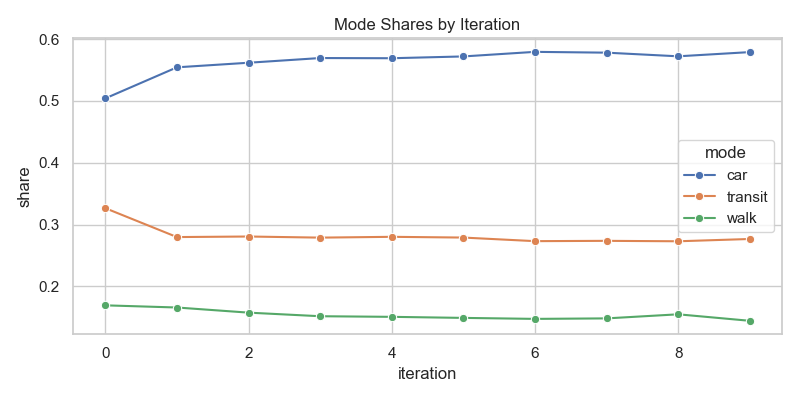

In [24]:
from IPython.display import Image

Image(filename=str(mode_share_plot_path))

## Incremental Computation Demo

We ran the baseline scenario for 10 iterations above. Now we'll run an extended scenario for15 iterations. Since the extended run shares the same parameters for iterations 0-9, Consistshould recognize those steps have already been computed and skip them—only running iterations 10through 14.


In [ ]:
extended_config = replace(base_config, n_iterations=15)
extended_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_extended"
extended_results = run_scenario(extended_config, extended_run_id)

  7%|▋         | 1/15 [00:05<01:17,  5.51s/it]

In [ ]:
# Quick cache-hit check for the extended run.
cached_runs = [
    run
    for run in tracker.find_runs(parent_id=extended_results["scenario_run_id"])
    if run.meta.get("cache_hit")
]
[(run.model_name, run.iteration, run.id) for run in cached_runs]

As expected, all steps from iterations 0-9 were retrieved from cache. The extended run only
computed the 5 new iterations, demonstrating how Consist enables incremental refinement of
iterative models.


## Querying Provenance

Now let's use Consist's query capabilities to explore the artifact lineage. We can find all the model runs in a given iteration


In [ ]:
# Runs for a specific iteration (e.g., iteration 5).
iteration_runs = [
    run
    for run in tracker.find_runs(parent_id=SCENARIO_RUN_ID, status="completed")
    if run.iteration == 5
]
iteration_run_df = pd.DataFrame(
    [
        {
            "model": run.model_name,
            "run_id": run.id,
            "iteration": run.iteration,
        }
        for run in iteration_runs
    ]
)
iteration_run_df



We can find all the artifacts created during that iteration

In [ ]:
iter5_artifacts = {
    run.id: [artifact.key for artifact in tracker.find_artifacts(creator=run)]
    for run in iteration_runs
}
iter5_artifacts

### Artifact Lineage

The lineage tree shows how the final `skims` artifact traces back through the computational graph. Reading the tree:

- Each **artifact** (like `skims`, `volumes`) shows its key and unique ID
- Below each artifact is the **run** that produced it, with the step name, run ID, and iteration number
- Indented below each run are its **input artifacts**, which recursively show their own producers

This forms a DAG (directed acyclic graph) where you can trace any output back to the original inputs. With `max_depth=4`, we see four levels of this chain—in a 10-iteration model, the full lineage would be much deeper.

In [ ]:
from rich import print as rprint
from rich.tree import Tree



def _add_lineage(branch, node):
    artifact = node["artifact"]
    art_label = f"{artifact.key} ({artifact.id})"
    art_branch = branch.add(art_label)
    run_node = node.get("producing_run")
    if not run_node:
        return
    run = run_node["run"]
    run_label = f"{run.model_name} run={run.id} iter={run.iteration}"
    run_branch = art_branch.add(run_label)
    for child in run_node.get("inputs", []):
        _add_lineage(run_branch, child)

final_skims = tracker.get_artifact("skims")
lineage = (
    tracker.get_artifact_lineage(final_skims.id, max_depth=4) if final_skims else None
)

if lineage:
    tree = Tree("lineage")
    _add_lineage(tree, lineage)
    rprint(tree)

In [ ]:
# Which steps would re-run if parking costs changed?
# Parking costs live in the zones artifact, so any run that consumes 'zones'
# would be invalidated.
zone_consumers = []
for run in tracker.find_runs(parent_id=SCENARIO_RUN_ID, status="completed"):
    artifacts = tracker.get_artifacts_for_run(run.id)
    if "zones" in artifacts.inputs:
        zone_consumers.append(run)
zone_consumer_df = pd.DataFrame(
    [
        {"model": run.model_name, "run_id": run.id, "iteration": run.iteration}
        for run in zone_consumers
    ]
)
zone_consumer_df

## Summary

This notebook demonstrated three key provenance patterns:

1. **Deep chains**: Each iteration's outputs become the next iteration's inputs, creating
   traceable lineage dozens of steps deep.
2. **Incremental computation**: Running 15 iterations after already running 10 reused all
   prior work—only the new iterations executed.
3. **Impact analysis**: We can query which steps consume a given artifact to understand
   what would need to re-run if that artifact changed.

The transportation model is a toy example, but the patterns apply to any iterative workflow:
MCMC sampling, neural network training checkpoints, agent-based simulations, economic
equilibrium models.
